In [1]:
import numpy as np
import pandas as pd

import re
from pattern.en import suggest
from collections import Counter

import gensim
from tqdm import tqdm
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, CuDNNLSTM, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Bhaskar Boora\Anaconda3\envs\tf-gpu\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
df = pd.read_csv('D:/Datasets/mc-sent-2/dataset/hm_train.csv', low_memory=False)
df.cleaned_hm = df.cleaned_hm.apply(str.lower)
df.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,i went on a successful date with someone i fel...,1,affection
1,27674,24h,i was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,i went to the gym this morning and did yoga.,1,exercise
3,27676,24h,we had a serious talk with some friends of our...,2,bonding
4,27677,24h,i went with grandchildren to butterfly display...,1,affection


In [3]:
labels = df.predicted_category
df.drop(['reflection_period', 'num_sentence', 'predicted_category'], axis=1, inplace=True)
classes = sorted(labels.unique())

In [4]:
classes

['achievement',
 'affection',
 'bonding',
 'enjoy_the_moment',
 'exercise',
 'leisure',
 'nature']

In [5]:
df_train, df_val, y_train, y_val = train_test_split(df, labels, test_size=0.15, random_state=7)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.cleaned_hm)
num_words = len(tokenizer.word_index) + 1

In [7]:
encoded_train_set = tokenizer.texts_to_sequences(df_train.cleaned_hm)
len(encoded_train_set)

51272

In [8]:
df_train['tokens'] = encoded_train_set
df_train.drop(['cleaned_hm'], axis=1, inplace=True)
df_train.head()

C:\Users\Bhaskar Boora\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Bhaskar Boora\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,hmid,tokens
45032,72952,"[6, 113, 13, 24, 15, 24, 13, 1, 77, 8, 33, 9019]"
48648,76580,"[72, 831, 6, 262, 1, 147, 494, 37, 95]"
30240,58081,"[2, 2408, 3196, 556, 30, 42, 178, 77, 16, 2135..."
30184,58025,"[1, 356, 8, 32, 715, 161, 929, 53, 4, 7, 47, 5..."
54765,82717,"[1, 35, 310, 1307, 609, 30, 551, 8, 2, 327, 406]"


In [9]:
y_train.head()

45032    enjoy_the_moment
48648         achievement
30240           affection
30184           affection
54765         achievement
Name: predicted_category, dtype: object

In [10]:
max_len = 100
padded = pad_sequences(encoded_train_set, maxlen=max_len, padding='post')
trainset = [list(doc) for doc in padded]
df_train['tokens'] = trainset
df_train.head()

C:\Users\Bhaskar Boora\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,hmid,tokens
45032,72952,"[6, 113, 13, 24, 15, 24, 13, 1, 77, 8, 33, 901..."
48648,76580,"[72, 831, 6, 262, 1, 147, 494, 37, 95, 0, 0, 0..."
30240,58081,"[2, 2408, 3196, 556, 30, 42, 178, 77, 16, 2135..."
30184,58025,"[1, 356, 8, 32, 715, 161, 929, 53, 4, 7, 47, 5..."
54765,82717,"[1, 35, 310, 1307, 609, 30, 551, 8, 2, 327, 40..."


In [11]:
encoded_val_set = tokenizer.texts_to_sequences(df_val.cleaned_hm)
print(len(encoded_val_set))

df_val['tokens'] = encoded_val_set
df_val.drop(['cleaned_hm'], axis=1, inplace=True)
padded_val = pad_sequences(encoded_val_set, maxlen=max_len, padding='post')
valset = [list(doc) for doc in padded_val]
df_val['tokens'] = valset;
df_val.head()

9049


C:\Users\Bhaskar Boora\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Bhaskar Boora\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,hmid,tokens
19748,47530,"[1, 65, 3, 163, 1091, 360, 16, 409, 53, 0, 0, ..."
26811,54629,"[1, 17, 5, 701, 2634, 6, 2105, 0, 0, 0, 0, 0, ..."
52605,80546,"[1, 91, 2, 129, 3, 27, 3938, 0, 0, 0, 0, 0, 0,..."
7848,35577,"[523, 41, 59, 19, 2873, 13, 1, 19, 75, 84, 41,..."
3435,31130,"[2, 231, 7, 619, 8, 6, 327, 0, 0, 0, 0, 0, 0, ..."


This time, find the optimal learning rate before training, to ensure the algorithm is converging to the global minima.

In [12]:
class LRFinder(Callback):

    '''
    lrf = LRFinder(minimum=3e-6, maximum=3e-4, step_size=(train_generator.n//train_generator.batch_size), n_epochs=4)
    model.fit(x_train, y_train, callbacks=[lrf, ])

    lrf.lr_graph()
    lrf.loss_graph()
    '''

    def __init__(self, minimum=1e-5, maximum=1e-2, step_size=None, n_epochs=None):
        super().__init__()
        self.minimum = minimum
        self.maximum = maximum
        self.i = 0
        self.num_iter = step_size * n_epochs
        self.history = {} # mandatory keras dictionary

    def calculate_learning_rate(self):
        x = self.i / self.num_iter
        return self.minimum + (self.maximum - self.minimum) * x

    # mandatory function for callbacks
    def on_train_begin(self, logs=None):
        if logs is None:
            logs = {}
        K.set_value(self.model.optimizer.lr, self.minimum)

    # mandatory function for callbacks
    def on_batch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        self.i += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.i)

        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

        K.set_value(self.model.optimizer.lr, self.calculate_learning_rate())

    # plot learning rate
    def lr_graph(self):
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('i')
        plt.ylabel('lr')
        plt.show()

    # plot loss
    def loss_graph(self):
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('lr')
        plt.ylabel('loss')
        plt.show()

In [13]:
inputs = Input(shape=(max_len,), dtype='int32')
embedding = Embedding(num_words, 200, input_length=max_len, trainable=True)(inputs)
x = CuDNNLSTM(256, return_sequences=True)(embedding)
x = CuDNNLSTM(64)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)
model = Model(inputs, outputs)

In [14]:
x_train = np.array([np.array(x) for x in df_train.tokens])
x_val = np.array([np.array(x) for x in df_val.tokens])
print(x_train.shape, x_val.shape)

label_to_ohv = dict()
for i, cls in enumerate(classes):
    ohv = np.zeros((7), dtype='int8')
    ohv[i] = 1
    label_to_ohv[cls] = tuple(ohv)
    
ohv_to_label = dict()
for k, v in label_to_ohv.items():
    ohv_to_label[v] = k

y_train = np.array([np.array(label_to_ohv[label]) for label in y_train])
y_val = np.array([np.array(label_to_ohv[label]) for label in y_val])
print(y_train.shape, y_val.shape)

(51272, 100) (9049, 100)
(51272, 7) (9049, 7)


In [15]:
lrf = LRFinder(1e-6, 1e-2, step_size=x_train.shape[0], n_epochs=4)
checkpoint = ModelCheckpoint('D:/Datasets/mc-sent-2/embedding_v2.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 200)          3980800   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 256)          468992    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 64)                82432     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 4,536,839
Trainable params: 4,536,839
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          callbacks=[checkpoint, lrf],
          epochs=4,
          verbose=2)

Train on 51272 samples, validate on 9049 samples
Epoch 1/4
 - 39s - loss: 1.6009 - categorical_accuracy: 0.3312 - val_loss: 1.5281 - val_categorical_accuracy: 0.3481
Epoch 2/4
 - 38s - loss: 1.5314 - categorical_accuracy: 0.3451 - val_loss: 1.5332 - val_categorical_accuracy: 0.3426
Epoch 3/4
 - 38s - loss: 1.4931 - categorical_accuracy: 0.3982 - val_loss: 1.5331 - val_categorical_accuracy: 0.3424
Epoch 4/4
 - 39s - loss: 1.5326 - categorical_accuracy: 0.3383 - val_loss: 1.5303 - val_categorical_accuracy: 0.3378


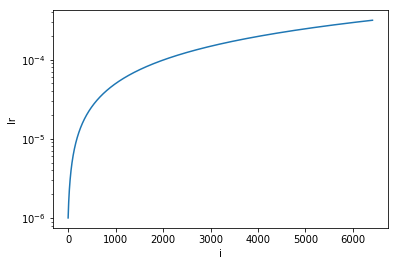

In [18]:
lrf.lr_graph()

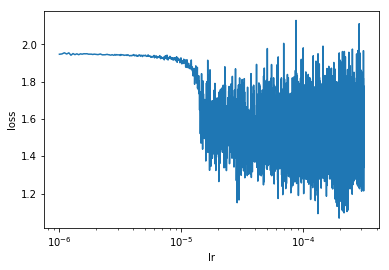

In [19]:
lrf.loss_graph()

Anything less than $10^{-4}$ seems to be a good learning rate to use. Going lower would require more epochs.

In [20]:
checkpoint = ModelCheckpoint('D:/Datasets/mc-sent-2/embedding_v3.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
model.compile(optimizer=Adam(lr=4e-5), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()
model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          callbacks=[checkpoint],
          epochs=12,
          verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 200)          3980800   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 256)          468992    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 64)                82432     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 4,536,839
Trainable params: 4,536,839
Non-trainable params: 0
_________________________________________________________________


In [21]:
model = load_model('D:/Datasets/mc-sent-2/embedding_v3.h5')

In [22]:
df_test = pd.read_csv('D:/Datasets/mc-sent-2/dataset/hm_test.csv', low_memory=False)
df_test.drop(['reflection_period', 'num_sentence'], axis=1, inplace=True)
df_test.head()

,hmid,cleaned_hm
0,88305,I spent the weekend in Chicago with my friends.
1,88306,We moved back into our house after a remodel. ...
2,88307,My fiance proposed to me in front of my family...
3,88308,I ate lobster at a fancy restaurant with some ...
4,88309,I went out to a nice restaurant on a date with...


In [23]:
encoded_test_set = tokenizer.texts_to_sequences(df_test.cleaned_hm)
df_test['tokens'] = encoded_test_set
df_test.drop(['cleaned_hm'], axis=1, inplace=True)
df_test.head()

,hmid,tokens
0,88305,"[1, 207, 6, 179, 9, 1877, 12, 2, 49]"
1,88306,"[21, 433, 105, 144, 51, 119, 44, 3, 5193, 21, ..."
2,88307,"[2, 702, 1766, 5, 10, 9, 579, 11, 2, 50, 9, 6,..."
3,88308,"[1, 167, 4087, 20, 3, 1538, 246, 12, 41, 49]"
4,88309,"[1, 23, 29, 5, 3, 87, 246, 16, 3, 326, 12, 2, ..."


In [24]:
padded_test = pad_sequences(encoded_test_set, maxlen=max_len, padding='post')
testset = [list(doc) for doc in padded_test]
df_test['tokens'] = testset;
df_test.head()

,hmid,tokens
0,88305,"[1, 207, 6, 179, 9, 1877, 12, 2, 49, 0, 0, 0, ..."
1,88306,"[21, 433, 105, 144, 51, 119, 44, 3, 5193, 21, ..."
2,88307,"[2, 702, 1766, 5, 10, 9, 579, 11, 2, 50, 9, 6,..."
3,88308,"[1, 167, 4087, 20, 3, 1538, 246, 12, 41, 49, 0..."
4,88309,"[1, 23, 29, 5, 3, 87, 246, 16, 3, 326, 12, 2, ..."


In [25]:
x_test = np.array([np.array(x) for x in df_test.tokens])
print(x_test.shape)

(40213, 100)


In [26]:
preds = model.predict(x_test, batch_size=32, verbose=2)
preds.shape

(40213, 7)

In [27]:
ohvs = []
for pred in preds:
    ohv = np.zeros((7), dtype='int8')
    ohv[np.argmax(pred)] = 1
    ohvs.append(ohv)

In [28]:
predictions = [ohv_to_label[tuple(vec)] for vec in ohvs]
df_test['predicted_category'] = predictions

In [29]:
df_test.drop(['tokens'], axis=1, inplace=True)
df_test.head()

,hmid,predicted_category
0,88305,bonding
1,88306,achievement
2,88307,affection
3,88308,bonding
4,88309,affection


In [30]:
df_test.to_csv('D:/Datasets/mc-sent-2/sub_3.csv', index=False)